## Dependencies

In [1]:
import pandas as pd
import numpy as np
import json
import re 
import sys
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

## Summary:

## 1. Data Exploration/Preparation

Download datasets here:
https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks

In [3]:
spotify_df = pd.read_csv('data.csv')

In [4]:
spotify_df.head()

acousticness                                   artists  danceability  \
0         0.995                       ['Carl Woitschach']         0.708   
1         0.994  ['Robert Schumann', 'Vladimir Horowitz']         0.379   
2         0.604                   ['Seweryn Goszczyński']         0.749   
3         0.995                      ['Francisco Canaro']         0.781   
4         0.990  ['Frédéric Chopin', 'Vladimir Horowitz']         0.210   

   duration_ms  energy  explicit                      id  instrumentalness  \
0       158648  0.1950         0  6KbQ3uYMLKb5jDxLF7wYDD             0.563   
1       282133  0.0135         0  6KuQTIu1KoTTkLXKrwlLPV             0.901   
2       104300  0.2200         0  6L63VW0PibdM1HDSBoqnoM             0.000   
3       180760  0.1300         0  6M94FkXd15sOAOQYRnWPN8             0.887   
4       687733  0.2040         0  6N6tiFZ9vLTSOIxkj8qKrd             0.908   

   key  liveness  loudness  mode  \
0   10    0.1510   -12.428     1   
1    8    0.0763   -28.454     1   
2    5    0.1190   -19.924     0   
3    1    0.1110   -14.734     0   
4   11    0.0980   -16.829     1   

                                            name  popularity release_date  \
0                    Singende Bataillone 1. Teil           0         1928   
1       Fantasiestücke, Op. 111: Più tosto lento           0         1928   
2                 Chapter 1.18 - Zamek kaniowski           0         1928   
3  Bebamos Juntos - Instrumental (Remasterizado)           0   1928-09-25   
4    Polonaise-Fantaisie in A-Flat Major, Op. 61           1         1928   

   speechiness    tempo  valence  year  
0       0.0506  118.469   0.7790  1928  
1       0.0462   83.972   0.0767  1928  
2       0.9290  107.177   0.8800  1928  
3       0.0926  108.003   0.7200  1928  
4       0.0424   62.149   0.0693  1928

Observations:
1. This data is at a **song level**
2. Many numerical values that I'll be able to use to compare movies (liveness, tempo, valence, etc)
2. Release date will useful but I'll need to create a OHE variable for release date in 5 year increments
3. Similar to 2, I'll need to create OHE variables for the popularity. I'll also use 5 year increments here
4. There is nothing here related to the genre of the song which will be useful. This data alone won't help us find relavent content since this is a content based recommendation system. Fortunately there is a `data_w_genres.csv` file that should have some useful information

In [5]:
data_w_genre = pd.read_csv('data_w_genres.csv')
data_w_genre.head()

artists  acousticness  \
0                   "Cats" 1981 Original London Cast      0.575083   
1                          "Cats" 1983 Broadway Cast      0.862538   
2        "Fiddler On The Roof” Motion Picture Chorus      0.856571   
3     "Fiddler On The Roof” Motion Picture Orchestra      0.884926   
4  "Joseph And The Amazing Technicolor Dreamcoat"...      0.605444   

   danceability    duration_ms    energy  instrumentalness  liveness  \
0      0.442750  247260.000000  0.386336          0.022717  0.287708   
1      0.441731  287280.000000  0.406808          0.081158  0.315215   
2      0.348286  328920.000000  0.286571          0.024593  0.325786   
3      0.425074  262890.962963  0.245770          0.073587  0.275481   
4      0.437333  232428.111111  0.429333          0.037534  0.216111   

    loudness  speechiness       tempo   valence  popularity  key  mode  count  \
0 -14.205417     0.180675  115.983500  0.334433   38.000000    5     1     12   
1 -10.690000     0.176212  103.044154  0.268865   33.076923    5     1     26   
2 -15.230714     0.118514   77.375857  0.354857   34.285714    0     1      7   
3 -15.639370     0.123200   88.667630  0.372030   34.444444    0     1     27   
4 -11.447222     0.086000  120.329667  0.458667   42.555556   11     1      9   

           genres  
0  ['show tunes']  
1              []  
2              []  
3              []  
4              []

Observations:
1. This data is at an **artist level**
2. There are similar continuous variables as our initial dataset but I won't use this. I'll just use the values int he previous dataset. 
3. The genres are going to be really useful here and I'll need to use it moving forward. Now, the genre column appears to be in a list format but my past experience tells me that it's likely not. Let's investigate this further.

In [6]:
data_w_genre.dtypes

artists              object
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
popularity          float64
key                   int64
mode                  int64
count                 int64
genres               object
dtype: object

This checks whether or not `genres` is actually in a list format:

In [7]:
data_w_genre['genres'].values[0]

"['show tunes']"

In [8]:
#To check if this is actually a list, let me index it and see what it returns
data_w_genre['genres'].values[0][0]

'['

As we can see, it's actually a string that looks like a list. Now, look at the example above, I'm going to put together a regex statement to extract the genre and input into a list

In [9]:
data_w_genre['genres_upd'] = data_w_genre['genres'].apply(lambda x: [re.sub(' ','_',i) for i in re.findall(r"'([^']*)'", x)])

In [10]:
data_w_genre['genres_upd'].values[0][0]

'show_tunes'

In [11]:
data_w_genre.head()

artists  acousticness  \
0                   "Cats" 1981 Original London Cast      0.575083   
1                          "Cats" 1983 Broadway Cast      0.862538   
2        "Fiddler On The Roof” Motion Picture Chorus      0.856571   
3     "Fiddler On The Roof” Motion Picture Orchestra      0.884926   
4  "Joseph And The Amazing Technicolor Dreamcoat"...      0.605444   

   danceability    duration_ms    energy  instrumentalness  liveness  \
0      0.442750  247260.000000  0.386336          0.022717  0.287708   
1      0.441731  287280.000000  0.406808          0.081158  0.315215   
2      0.348286  328920.000000  0.286571          0.024593  0.325786   
3      0.425074  262890.962963  0.245770          0.073587  0.275481   
4      0.437333  232428.111111  0.429333          0.037534  0.216111   

    loudness  speechiness       tempo   valence  popularity  key  mode  count  \
0 -14.205417     0.180675  115.983500  0.334433   38.000000    5     1     12   
1 -10.690000     0.176212  103.044154  0.268865   33.076923    5     1     26   
2 -15.230714     0.118514   77.375857  0.354857   34.285714    0     1      7   
3 -15.639370     0.123200   88.667630  0.372030   34.444444    0     1     27   
4 -11.447222     0.086000  120.329667  0.458667   42.555556   11     1      9   

           genres    genres_upd  
0  ['show tunes']  [show_tunes]  
1              []            []  
2              []            []  
3              []            []  
4              []            []

Voila, now we have the genre column in a format we can actually use. If you go down, you'll see how we use it. 

Now, if you recall, this data is at a artist level and the previous dataset is at a song level. So what here's what we need to do:
1. Explode artists column in the previous so each artist within a song will have their own row
2. Merge `data_w_genre` to the exploded dataset in Step 1 so that the previous dataset no is enriched with genre dataset

Before I go further, let's complete these two steps.

Step 1. 
Similar to before, we will need to extract the artists from the string list. 

In [12]:
spotify_df['artists_upd_v1'] = spotify_df['artists'].apply(lambda x: re.findall(r"'([^']*)'", x))


In [13]:
spotify_df['artists'].values[0]

"['Carl Woitschach']"

In [14]:
spotify_df['artists_upd_v1'].values[0][0]

'Carl Woitschach'

This looks good but did this work for every artist string format. Let's double check

In [15]:
spotify_df[spotify_df['artists_upd_v1'].apply(lambda x: not x)].head(5)

acousticness                                        artists  \
127          0.995  ["Sam Manning's and His Cole Jazz Orchestra"]   
180          0.984                           ["Scarlet D'Carpio"]   
1244         0.506       ["Original Broadway Cast Of 'Flahooley"]   
1478         0.809          ["Cal Tjader's Modern Mambo Quintet"]   
1944         0.804                      ["Screamin' Jay Hawkins"]   

      danceability  duration_ms  energy  explicit                      id  \
127          0.664       173333   0.283         0  42WDMm9hX0xCFkkKpt6NOY   
180          0.400       142443   0.190         0  4Gcc2YB0AAlzPLQhosdyAw   
1244         0.519        35227   0.475         0  1Qt9zpHUfVqMNr25EU9IFL   
1478         0.795       238200   0.386         0  5VeW5QJDW906P5knRgJWzt   
1944         0.574       142893   0.401         0  6MC85zBk1dQqnywRDdzy7h   

      instrumentalness  key  liveness  loudness  mode              name  \
127            0.87400    8     0.109   -18.301     0             Bungo   
180            0.90000    0     0.182   -12.062     1  Chililin Uth'aja   
1244           0.07100    7     0.103    -9.553     0          Prologue   
1478           0.87400    1     0.106   -14.984     1    Dearly Beloved   
1944           0.00002    2     0.546   -11.185     1      I Love Paris   

      popularity release_date  speechiness    tempo  valence  year  \
127            0   1930-01-01       0.0807   99.506    0.688  1930   
180            0         1930       0.0492   81.290    0.402  1930   
1244           0   1951-01-01       0.1070  105.639    0.615  1951   
1478           2   1954-09-11       0.0570  119.800    0.807  1954   
1944          14         1958       0.0533   89.848    0.587  1958   

     artists_upd_v1  
127              []  
180              []  
1244             []  
1478             []  
1944             []

So, it looks like it didn't catch all of them and you can quickly see that it's because artists with an apostrophe in their title and the fact that they are enclosed in a full quotes. I'll write another regex to handle this and then combine the two

In [16]:
spotify_df['artists_upd_v2'] = spotify_df['artists'].apply(lambda x: re.findall('\"(.*?)\"',x))
spotify_df['artists_upd'] = np.where(spotify_df['artists_upd_v1'].apply(lambda x: not x), spotify_df['artists_upd_v2'], spotify_df['artists_upd_v1'] )

In [17]:
#need to create my own song identifier because there are duplicates of the same song with different ids. I see different
spotify_df['artists_song'] = spotify_df.apply(lambda row: row['artists_upd'][0]+row['name'],axis = 1)

In [18]:
spotify_df.sort_values(['artists_song','release_date'], ascending = False, inplace = True)

In [19]:
spotify_df[spotify_df['name']=='Adore You']

acousticness           artists  danceability  duration_ms  energy  \
97046        0.1110   ['Miley Cyrus']         0.583       278747   0.655   
87868        0.0237  ['Harry Styles']         0.676       207133   0.771   
87883        0.0237  ['Harry Styles']         0.676       207133   0.771   

       explicit                      id  instrumentalness  key  liveness  ...  \
97046         0  5AnCLGg35ziFOloEnXK4uu          0.000004    0     0.113  ...   
87868         0  3jjujdWJ72nww5eGnfs2E7          0.000007    8     0.102  ...   
87883         0  1M4qEo4HE3PRaCOM7EXNJq          0.000007    8     0.102  ...   

       popularity  release_date speechiness    tempo valence  year  \
97046          70    2013-10-04      0.0315  119.759   0.201  2013   
87868          88    2019-12-13      0.0483   99.048   0.569  2019   
87883          86    2019-12-06      0.0483   99.048   0.569  2019   

       artists_upd_v1  artists_upd_v2     artists_upd           artists_song  
97046   [Miley Cyrus]              []   [Miley Cyrus]   Miley CyrusAdore You  
87868  [Harry Styles]              []  [Harry Styles]  Harry StylesAdore You  
87883  [Harry Styles]              []  [Harry Styles]  Harry StylesAdore You  

[3 rows x 23 columns]

In [20]:
spotify_df.drop_duplicates('artists_song',inplace = True)

In [21]:
spotify_df[spotify_df['name']=='Adore You']

acousticness           artists  danceability  duration_ms  energy  \
97046        0.1110   ['Miley Cyrus']         0.583       278747   0.655   
87868        0.0237  ['Harry Styles']         0.676       207133   0.771   

       explicit                      id  instrumentalness  key  liveness  ...  \
97046         0  5AnCLGg35ziFOloEnXK4uu          0.000004    0     0.113  ...   
87868         0  3jjujdWJ72nww5eGnfs2E7          0.000007    8     0.102  ...   

       popularity  release_date speechiness    tempo valence  year  \
97046          70    2013-10-04      0.0315  119.759   0.201  2013   
87868          88    2019-12-13      0.0483   99.048   0.569  2019   

       artists_upd_v1  artists_upd_v2     artists_upd           artists_song  
97046   [Miley Cyrus]              []   [Miley Cyrus]   Miley CyrusAdore You  
87868  [Harry Styles]              []  [Harry Styles]  Harry StylesAdore You  

[2 rows x 23 columns]

Now I can explode this column and merge as I planned to in `Step 2`

In [22]:
artists_exploded = spotify_df[['artists_upd','id']].explode('artists_upd')

In [23]:
artists_exploded_enriched = artists_exploded.merge(data_w_genre, how = 'left', left_on = 'artists_upd',right_on = 'artists')
artists_exploded_enriched_nonnull = artists_exploded_enriched[~artists_exploded_enriched.genres_upd.isnull()]

In [24]:
artists_exploded_enriched_nonnull[artists_exploded_enriched_nonnull['id'] =='6KuQTIu1KoTTkLXKrwlLPV']

artists_upd                      id            artists  \
51108    Robert Schumann  6KuQTIu1KoTTkLXKrwlLPV    Robert Schumann   
51109  Vladimir Horowitz  6KuQTIu1KoTTkLXKrwlLPV  Vladimir Horowitz   

       acousticness  danceability    duration_ms    energy  instrumentalness  \
51108       0.98417      0.362023  212320.169960  0.105301          0.782029   
51109       0.99007      0.343210  266541.125104  0.118844          0.879508   

       liveness   loudness  speechiness      tempo   valence  popularity  key  \
51108  0.160324 -22.831075     0.048055  98.447067  0.277442    3.723320  5.0   
51109  0.183812 -23.193418     0.043360  94.900679  0.225951    3.592378  1.0   

       mode   count                                             genres  \
51108   1.0   253.0                ['classical', 'early romantic era']   
51109   1.0  1207.0  ['classical', 'classical performance', 'classi...   

                                              genres_upd  
51108                    [classical, early_romantic_era]  
51109  [classical, classical_performance, classical_p...

Alright we're almost their, now we need to:
1. Group by on the song `id` and essentially create lists lists
2. Consilidate these lists and output the unique values

In [25]:
artists_genres_consolidated = artists_exploded_enriched_nonnull.groupby('id')['genres_upd'].apply(list).reset_index()

In [26]:
artists_genres_consolidated['consolidates_genre_lists'] = artists_genres_consolidated['genres_upd'].apply(lambda x: list(set(list(itertools.chain.from_iterable(x)))))

In [27]:
artists_genres_consolidated.head()

id                                         genres_upd  \
0  000G1xMMuwxNHmwVsBdtj1  [[candy_pop, dance_rock, new_romantic, new_wav...   
1  000ZxLGm7jDlWCHtcXSeBe    [[boogie-woogie, piano_blues, ragtime, stride]]   
2  000jBcNljWTnyjB4YO7ojf                                               [[]]   
3  000mGrJNc2GAgQdMESdgEc  [[classical, late_romantic_era], [historic_orc...   
4  000u1dTg7y1XCDXi80hbBX            [[country, country_road, country_rock]]   

                            consolidates_genre_lists  
0  [permanent_wave, power_pop, new_wave_pop, new_...  
1      [boogie-woogie, stride, ragtime, piano_blues]  
2                                                 []  
3  [late_romantic_era, orchestral_performance, hi...  
4              [country, country_road, country_rock]

In [28]:
spotify_df = spotify_df.merge(artists_genres_consolidated[['id','consolidates_genre_lists']], on = 'id',how = 'left')

## 2. Feature Engineering

### - Normalize float variables
### - OHE Year and Popularity Variables
### - Create TF-IDF features off of artist genres

In [29]:
spotify_df.tail()

acousticness                                         artists  \
155464        0.0287                    ["Livin' Joy", 'A. Manetta']   
155465        0.0218                            ["Lil' Flip", 'Lea']   
155466        0.0516  ["Ol' Dirty Bastard", 'Kelis', 'Rich Travali']   
155467        0.0249      ["World Class Wreckin' Cru", "Michel 'Le"]   
155468        0.0113      ["Rappin' 4-Tay", 'MC Breed', 'Too $hort']   

        danceability  duration_ms  energy  explicit                      id  \
155464         0.704       215227   0.722         0  5cIU5GZBbyMfgfXGcoQVYc   
155465         0.845       225187   0.346         0  3FaUH7ZMjW1hv9Jx6MIAIf   
155466         0.934       239547   0.459         1  6YYd5MLpu45J0uLrMdivF7   
155467         0.715       351040   0.490         0  3hoiinUc5VA9xUEJID7R8V   
155468         0.897       337973   0.414         1  78859Af0fmA9VTlgnOHTAP   

        instrumentalness  key  liveness  ...  release_date  speechiness  \
155464           0.00341    2     0.297  ...    1997-01-01       0.0446   
155465           0.00000    0     0.135  ...    2004-03-30       0.1060   
155466           0.00000    1     0.222  ...          1999       0.1890   
155467           0.00017    9     0.139  ...    1994-04-06       0.0479   
155468           0.00011    4     0.101  ...          1996       0.2460   

          tempo  valence  year           artists_upd_v1  \
155464  129.992    0.859  1997                [ Joy", ]   
155465   93.989    0.819  2004               [ Flip", ]   
155466  103.040    0.697  1999  [ Dirty Bastard", , , ]   
155467  129.309    0.429  1994        [ Cru", "Michel ]   
155468   96.039    0.273  1996          [ 4-Tay", , , ]   

                                artists_upd_v2              artists_upd  \
155464                            [Livin' Joy]                [ Joy", ]   
155465                             [Lil' Flip]               [ Flip", ]   
155466                     [Ol' Dirty Bastard]  [ Dirty Bastard", , , ]   
155467  [World Class Wreckin' Cru, Michel 'Le]        [ Cru", "Michel ]   
155468                         [Rappin' 4-Tay]          [ 4-Tay", , , ]   

                                         artists_song consolidates_genre_lists  
155464            Joy", Don't Stop Movin' - Radio Mix                      NaN  
155465                    Flip", Sunshine (feat. Lea)                      NaN  
155466   Dirty Bastard", Got Your Money (feat. Kelis)                      NaN  
155467        Cru", "Michel Turn Off The Lights - Rap                      NaN  
155468                        4-Tay", Never Talk Down                      NaN  

[5 rows x 24 columns]

In [30]:
spotify_df['year'] = spotify_df['release_date'].apply(lambda x: x.split('-')[0])

In [31]:
spotify_df['year'].head()

0    1992
1    1968
2    1968
3    1968
4    1968
Name: year, dtype: object

In [32]:
float_cols = spotify_df.dtypes[spotify_df.dtypes == 'float64'].index.values

In [33]:
ohe_cols = 'popularity'

In [34]:
spotify_df['popularity'].describe()

count    155469.000000
mean         31.306987
std          21.422973
min           0.000000
25%          12.000000
50%          33.000000
75%          48.000000
max          97.000000
Name: popularity, dtype: float64

In [35]:
# create 5 point buckets for popularity 
spotify_df['popularity_red'] = spotify_df['popularity'].apply(lambda x: int(x/5))

In [36]:
spotify_df['popularity_red'].describe()

count    155469.000000
mean          5.927619
std           4.197556
min           0.000000
25%           2.000000
50%           6.000000
75%           9.000000
max          19.000000
Name: popularity_red, dtype: float64

In [37]:
# tfidf can't handle nulls so fill any null values with an empty list
spotify_df['consolidates_genre_lists'] = spotify_df['consolidates_genre_lists'].apply(lambda d: d if isinstance(d, list) else [])

In [38]:
spotify_df.head()

acousticness  artists  danceability  duration_ms  energy  explicit  \
0         0.381   ['黑豹']         0.353       316160  0.6860         0   
1         0.978  ['黃蜀娟']         0.153       156813  0.0581         0   
2         0.828  ['黃蜀娟']         0.508       100133  0.2470         0   
3         0.909  ['黃蜀娟']         0.140       284040  0.1310         0   
4         0.944  ['黃蜀娟']         0.604       173627  0.2100         0   

                       id  instrumentalness  key  liveness  ...  speechiness  \
0  3KIuCzckjdeeVuswPo20mC          0.000000   11    0.0568  ...       0.0395   
1  7dkMnOK1h9I3D2NyDDjBfh          0.000939   10    0.1550  ...       0.0472   
2  7ilXPF7IilGtVX4MMubQfQ          0.000000    3    0.2970  ...       0.1730   
3  3enJcaHwRwN3ABPp3Bae35          0.000042   10    0.6190  ...       0.0455   
4  6aewX7cGeXnZTK36bZRI6T          0.000007    0    0.2110  ...       0.0395   

     tempo valence  year artists_upd_v1  artists_upd_v2  artists_upd  \
0  200.341  0.3520  1992           [黑豹]              []         [黑豹]   
1  174.060  0.0904  1968          [黃蜀娟]              []        [黃蜀娟]   
2  170.629  0.6800  1968          [黃蜀娟]              []        [黃蜀娟]   
3   82.543  0.1160  1968          [黃蜀娟]              []        [黃蜀娟]   
4  105.531  0.5380  1968          [黃蜀娟]              []        [黃蜀娟]   

             artists_song             consolidates_genre_lists popularity_red  
0  黑豹DON'T BREAK MY HEART  [chinese_indie_rock, chinese_indie]              6  
1                 黃蜀娟輕煙濃霧                                   []              4  
2                 黃蜀娟踏雪尋梅                                   []              4  
3                黃蜀娟藍色的月光                                   []              4  
4                 黃蜀娟薔薇之戀                                   []              4  

[5 rows x 25 columns]

In [39]:
#simple function to create OHE features
#this gets passed later on
def ohe_prep(df, column, new_name): 
    """ 
    Create One Hot Encoded features of a specific column

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        column (str): Column to be processed
        new_name (str): new column name to be used
        
    Returns: 
        tf_df: One hot encoded features 
    """
    
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df


In [40]:
#function to build entire feature set
def create_feature_set(df, float_cols):
    """ 
    Process spotify df to create a final set of features that will be used to generate recommendations

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        float_cols (list(str)): List of float columns that will be scaled 
        
    Returns: 
        final: final set of features 
    """
    
    #tfidf genre lists
    tfidf = TfidfVectorizer()
    tfidf_matrix =  tfidf.fit_transform(df['consolidates_genre_lists'].apply(lambda x: " ".join(x)))
    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names()]
    genre_df.reset_index(drop = True, inplace=True)

    #explicity_ohe = ohe_prep(df, 'explicit','exp')    
    year_ohe = ohe_prep(df, 'year','year') * 0.5
    popularity_ohe = ohe_prep(df, 'popularity_red','pop') * 0.15

    #scale float columns
    floats = df[float_cols].reset_index(drop = True)
    scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns) * 0.2

    #concanenate all features
    final = pd.concat([genre_df, floats_scaled, popularity_ohe, year_ohe], axis = 1)
     
    #add song id
    final['id']=df['id'].values
    
    return final

In [41]:
complete_feature_set = create_feature_set(spotify_df, float_cols=float_cols)#.mean(axis = 0)

In [42]:
complete_feature_set.head()

genre|432hz  genre|_hip_hop  genre|a_cappella  genre|abstract  \
0          0.0             0.0               0.0             0.0   
1          0.0             0.0               0.0             0.0   
2          0.0             0.0               0.0             0.0   
3          0.0             0.0               0.0             0.0   
4          0.0             0.0               0.0             0.0   

   genre|abstract_beats  genre|abstract_hip_hop  genre|accordeon  \
0                   0.0                     0.0              0.0   
1                   0.0                     0.0              0.0   
2                   0.0                     0.0              0.0   
3                   0.0                     0.0              0.0   
4                   0.0                     0.0              0.0   

   genre|accordion  genre|acid_house  genre|acid_jazz  ...  year|2012  \
0              0.0               0.0              0.0  ...        0.0   
1              0.0               0.0              0.0  ...        0.0   
2              0.0               0.0              0.0  ...        0.0   
3              0.0               0.0              0.0  ...        0.0   
4              0.0               0.0              0.0  ...        0.0   

   year|2013  year|2014  year|2015  year|2016  year|2017  year|2018  \
0        0.0        0.0        0.0        0.0        0.0        0.0   
1        0.0        0.0        0.0        0.0        0.0        0.0   
2        0.0        0.0        0.0        0.0        0.0        0.0   
3        0.0        0.0        0.0        0.0        0.0        0.0   
4        0.0        0.0        0.0        0.0        0.0        0.0   

   year|2019  year|2020                      id  
0        0.0        0.0  3KIuCzckjdeeVuswPo20mC  
1        0.0        0.0  7dkMnOK1h9I3D2NyDDjBfh  
2        0.0        0.0  7ilXPF7IilGtVX4MMubQfQ  
3        0.0        0.0  3enJcaHwRwN3ABPp3Bae35  
4        0.0        0.0  6aewX7cGeXnZTK36bZRI6T  

[5 rows x 2759 columns]

## 3. Connect to Spotify API

Useful links:
1. https://developer.spotify.com/dashboard/
2. https://spotipy.readthedocs.io/en/2.16.1/

In [43]:
#client id and secret for my application
with open('api_access.txt', 'r') as f:
    client_list = f.readlines()
client_id = client_list[0].strip('\n')
client_secret= client_list[1].strip('\n')

In [44]:
scope = 'user-library-read'

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()

In [45]:
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [46]:
token = util.prompt_for_user_token(scope, client_id= client_id, client_secret=client_secret, redirect_uri='http://localhost:8881/')

In [47]:
sp = spotipy.Spotify(auth=token)

In [48]:
#gather playlist names and images. 
#images aren't going to be used until I start building a UI
id_name = {}
list_photo = {}
for i in sp.current_user_playlists()['items']:

    id_name[i['name']] = i['uri'].split(':')[2]
    list_photo[i['uri'].split(':')[2]] = i['images'][0]['url']

In [49]:
id_name

{'Rap': '13aHzRREhCzdttPLoplfe3',
 'Classics': '23iQgfpb0FtNPanQhX2Ouv',
 'Pop': '54EBI96xqgWderbJVDegiB'}

In [50]:
def create_necessary_outputs(playlist_name,id_dic, df):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        playlist_name (str): name of the playlist you'd like to pull from the spotify API
        id_dic (dic): dictionary that maps playlist_name to playlist_id
        df (pandas dataframe): spotify datafram
        
    Returns: 
        playlist: all songs in the playlist THAT ARE AVAILABLE IN THE KAGGLE DATASET
    """
    
    #generate playlist dataframe
    playlist = pd.DataFrame()
    playlist_name = playlist_name

    for ix, i in enumerate(sp.playlist(id_dic[playlist_name])['tracks']['items']):
        #print(i['track']['artists'][0]['name'])
        playlist.loc[ix, 'artist'] = i['track']['artists'][0]['name']
        playlist.loc[ix, 'name'] = i['track']['name']
        playlist.loc[ix, 'id'] = i['track']['id'] # ['uri'].split(':')[2]
        playlist.loc[ix, 'url'] = i['track']['album']['images'][1]['url']
        playlist.loc[ix, 'date_added'] = i['added_at']

    playlist['date_added'] = pd.to_datetime(playlist['date_added'])  
    
    playlist = playlist[playlist['id'].isin(df['id'].values)].sort_values('date_added',ascending = False)
    
    return playlist

In [51]:
id_name

{'Rap': '13aHzRREhCzdttPLoplfe3',
 'Classics': '23iQgfpb0FtNPanQhX2Ouv',
 'Pop': '54EBI96xqgWderbJVDegiB'}

In [52]:
playlist_pop = create_necessary_outputs('Pop', id_name,spotify_df)
playlist_rap = create_necessary_outputs('Rap',id_name, spotify_df)
#playlist_classical = create_necessary_outputs('Epic Classical',id_name, spotify_df)

In [53]:
from skimage import io
import matplotlib.pyplot as plt

def visualize_songs(df):
    """ 
    Visualize cover art of the songs in the inputted dataframe

    Parameters: 
        df (pandas dataframe): Playlist Dataframe
    """
    
    temp = df['url'].values
    plt.figure(figsize=(15,int(0.625 * len(temp))))
    columns = 5
    
    for i, url in enumerate(temp):
        plt.subplot(int(len(temp) / columns + 1), columns, i + 1)

        image = io.imread(url)
        plt.imshow(image)
        plt.xticks(color = 'w', fontsize = 0.1)
        plt.yticks(color = 'w', fontsize = 0.1)
        plt.xlabel(df['name'].values[i], fontsize = 12)
        plt.tight_layout(h_pad=0.4, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()

In [54]:
playlist_pop.shape

(33, 5)

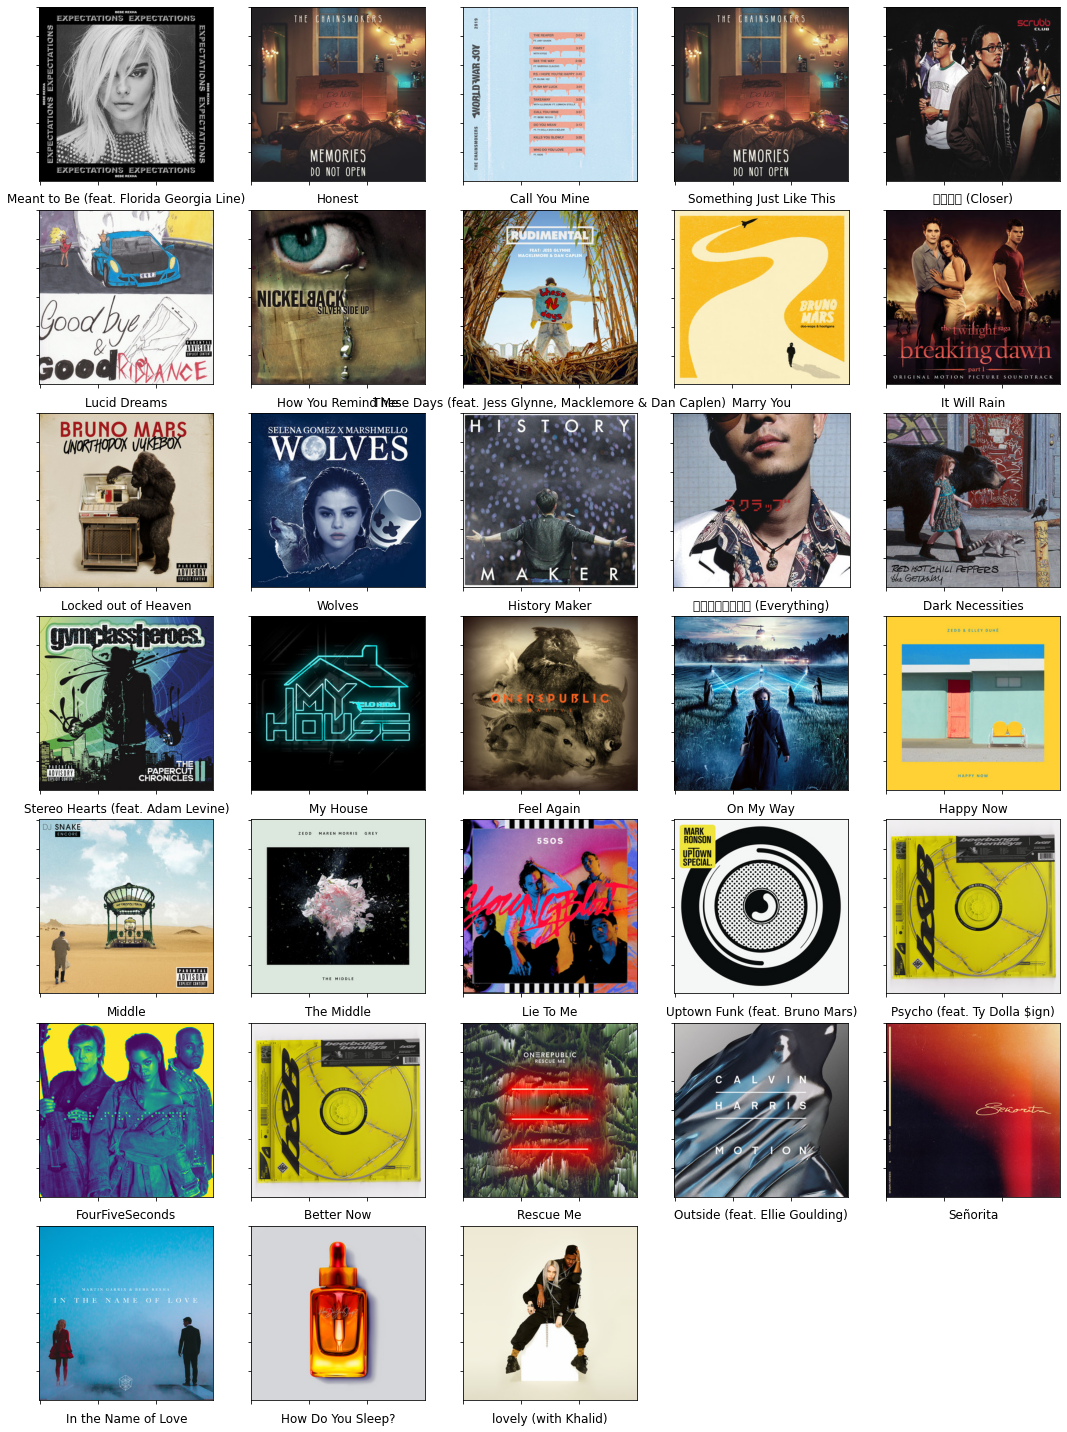

In [55]:
visualize_songs(playlist_pop)

## 4. Create Playlist Vector

In [56]:
def generate_playlist_feature(complete_feature_set, playlist_df, weight_factor):
    """ 
    Summarize a user's playlist into a single vector

    Parameters: 
        complete_feature_set (pandas dataframe): Dataframe which includes all of the features for the spotify songs
        playlist_df (pandas dataframe): playlist dataframe
        weight_factor (float): float value that represents the recency bias. The larger the recency bias, the most priority recent songs get. Value should be close to 1. 
        
    Returns: 
        playlist_feature_set_weighted_final (pandas series): single feature that summarizes the playlist
        complete_feature_set_nonplaylist (pandas dataframe): 
    """
    
    complete_feature_set_playlist = complete_feature_set[complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1).mean(axis =0)
    complete_feature_set_playlist = complete_feature_set_playlist.merge(playlist_df[['id','date_added']], on = 'id', how = 'inner')
    complete_feature_set_nonplaylist = complete_feature_set[~complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1)
    
    playlist_feature_set = complete_feature_set_playlist.sort_values('date_added',ascending=False)

    most_recent_date = playlist_feature_set.iloc[0,-1]
    
    for ix, row in playlist_feature_set.iterrows():
        playlist_feature_set.loc[ix,'months_from_recent'] = int((most_recent_date.to_pydatetime() - row.iloc[-1].to_pydatetime()).days / 30)
        
    playlist_feature_set['weight'] = playlist_feature_set['months_from_recent'].apply(lambda x: weight_factor ** (-x))
    
    playlist_feature_set_weighted = playlist_feature_set.copy()
    #print(playlist_feature_set_weighted.iloc[:,:-4].columns)
    playlist_feature_set_weighted.update(playlist_feature_set_weighted.iloc[:,:-4].mul(playlist_feature_set_weighted.weight,0))
    playlist_feature_set_weighted_final = playlist_feature_set_weighted.iloc[:, :-4]
    #playlist_feature_set_weighted_final['id'] = playlist_feature_set['id']
    
    return playlist_feature_set_weighted_final.sum(axis = 0), complete_feature_set_nonplaylist

In [57]:
complete_feature_set_playlist_vector_pop, complete_feature_set_nonplaylist_pop = generate_playlist_feature(complete_feature_set, playlist_pop, 1.01)
complete_feature_set_playlist_vector_rap, complete_feature_set_nonplaylist_rap = generate_playlist_feature(complete_feature_set, playlist_rap, 1.01)

In [58]:
complete_feature_set_playlist_vector_pop.shape

(2758,)

In [67]:
complete_feature_set_playlist_vector_pop.head()

genre|432hz             0.0
genre|_hip_hop          0.0
genre|a_cappella        0.0
genre|abstract          0.0
genre|abstract_beats    0.0
dtype: float64

## 5. Generate Recommendations

In [60]:
def generate_playlist_recos(df, features, nonplaylist_features):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        df (pandas dataframe): spotify dataframe
        features (pandas series): summarized playlist feature
        nonplaylist_features (pandas dataframe): feature set of songs that are not in the selected playlist
        
    Returns: 
        non_playlist_df_top_40: Top 40 recommendations for that playlist
    """
    
    non_playlist_df = df[df['id'].isin(nonplaylist_features['id'].values)]
    non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('id', axis = 1).values, features.values.reshape(1, -1))[:,0]
    non_playlist_df_top_40 = non_playlist_df.sort_values('sim',ascending = False).head(40)
    non_playlist_df_top_40['url'] = non_playlist_df_top_40['id'].apply(lambda x: sp.track(x)['album']['images'][1]['url'])
    
    return non_playlist_df_top_40

In [71]:
complete_feature_set_nonplaylist_pop.describe()

genre|432hz  genre|_hip_hop  genre|a_cappella  genre|abstract  \
count  155436.000000   155436.000000     155436.000000   155436.000000   
mean        0.000027        0.000976          0.000235        0.000022   
std         0.004919        0.021234          0.013905        0.002767   
min         0.000000        0.000000          0.000000        0.000000   
25%         0.000000        0.000000          0.000000        0.000000   
50%         0.000000        0.000000          0.000000        0.000000   
75%         0.000000        0.000000          0.000000        0.000000   
max         1.000000        0.627276          1.000000        0.406332   

       genre|abstract_beats  genre|abstract_hip_hop  genre|accordeon  \
count         155436.000000           155436.000000    155436.000000   
mean               0.000019                0.000172         0.000011   
std                0.003014                0.010242         0.003192   
min                0.000000                0.000000         0.000000   
25%                0.000000                0.000000         0.000000   
50%                0.000000                0.000000         0.000000   
75%                0.000000                0.000000         0.000000   
max                0.527022                1.000000         1.000000   

       genre|accordion  genre|acid_house  genre|acid_jazz  ...      year|2011  \
count    155436.000000     155436.000000    155436.000000  ...  155436.000000   
mean          0.000038          0.000072         0.000034  ...       0.006099   
std           0.005288          0.005787         0.005203  ...       0.054885   
min           0.000000          0.000000         0.000000  ...       0.000000   
25%           0.000000          0.000000         0.000000  ...       0.000000   
50%           0.000000          0.000000         0.000000  ...       0.000000   
75%           0.000000          0.000000         0.000000  ...       0.000000   
max           1.000000          0.656869         1.000000  ...       0.500000   

           year|2012      year|2013      year|2014     year|2015  \
count  155436.000000  155436.000000  155436.000000  155436.00000   
mean        0.005848       0.006060       0.006089       0.00597   
std         0.053757       0.054713       0.054842       0.05431   
min         0.000000       0.000000       0.000000       0.00000   
25%         0.000000       0.000000       0.000000       0.00000   
50%         0.000000       0.000000       0.000000       0.00000   
75%         0.000000       0.000000       0.000000       0.00000   
max         0.500000       0.500000       0.500000       0.50000   

           year|2016      year|2017      year|2018      year|2019  \
count  155436.000000  155436.000000  155436.000000  155436.000000   
mean        0.006105       0.006167       0.006167       0.006134   
std         0.054913       0.055184       0.055184       0.055042   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         0.500000       0.500000       0.500000       0.500000   

          year|2020  
count  155436.00000  
mean        0.00516  
std         0.05053  
min         0.00000  
25%         0.00000  
50%         0.00000  
75%         0.00000  
max         0.50000  

[8 rows x 2758 columns]

In [61]:
pop_top40 = generate_playlist_recos(spotify_df, complete_feature_set_playlist_vector_pop, complete_feature_set_nonplaylist_pop)

In [62]:
pop_top40

acousticness                            artists  danceability  \
149291       0.06390                   ['Ansel Elgort']         0.765   
77456        0.31700                      ['Lady Gaga']         0.553   
55140        0.39000                  ['Niykee Heaton']         0.751   
77433        0.68500                      ['Lady Gaga']         0.406   
146924       0.06910                        ['Ava Max']         0.719   
36896        0.09450                   ['Selena Gomez']         0.601   
67297        0.06700                   ['Madison Beer']         0.631   
148156       0.04000                  ['Ariana Grande']         0.699   
148153       0.10700                  ['Ariana Grande']         0.847   
65581        0.00987     ['Mark Ronson', 'Miley Cyrus']         0.601   
67300        0.40000                   ['Madison Beer']         0.583   
144737       0.34600        ['Bazzi', 'Camila Cabello']         0.638   
148165       0.18600                  ['Ariana Grande']         0.710   
135412       0.16600                 ['Camila Cabello']         0.650   
67292        0.30100                   ['Madison Beer']         0.673   
148203       0.02330                  ['Ariana Grande']         0.602   
148166       0.02110                  ['Ariana Grande']         0.568   
76423        0.49000         ['Lauv', 'Julia Michaels']         0.755   
135416       0.18100                 ['Camila Cabello']         0.637   
36897        0.09840                   ['Selena Gomez']         0.600   
148184       0.37500                  ['Ariana Grande']         0.831   
146927       0.10300                        ['Ava Max']         0.745   
148152       0.24800                  ['Ariana Grande']         0.721   
99456        0.03370  ['Hailee Steinfeld', 'BloodPop®']         0.661   
135428       0.60900                 ['Camila Cabello']         0.732   
148163       0.65700                  ['Ariana Grande']         0.604   
55076        0.50100              ['Noah Cyrus', 'MAX']         0.663   
148161       0.02170                  ['Ariana Grande']         0.708   
144516       0.00281                     ['Bebe Rexha']         0.630   
82591        0.04190                 ['Julia Michaels']         0.405   
144515       0.07810                     ['Bebe Rexha']         0.777   
148155       0.43000                  ['Ariana Grande']         0.652   
124390       0.79800                    ['Demi Lovato']         0.397   
143421       0.06860                        ['Beyoncé']         0.713   
136903       0.03400                     ['Bruno Mars']         0.818   
143395       0.00532                        ['Beyoncé']         0.896   
136883       0.01450                     ['Bruno Mars']         0.853   
135411       0.36700                 ['Camila Cabello']         0.545   
135426       0.64500                 ['Camila Cabello']         0.547   
77460        0.09870                      ['Lady Gaga']         0.666   

        duration_ms  energy  explicit                      id  \
149291       191493   0.622         1  2ZIZXWnU52s0C75sPYiwvh   
77456        210200   0.506         0  1koJk8rrMBlhDZ8MNiLzH9   
55140        227097   0.394         0  15jMztFtJ1mFFJ11SZvHHZ   
77433        328893   0.359         0  2fbJ5Msx8KoDKpyufH5YsU   
146924       187436   0.704         0  25sgk305KZfyuqVBQIahim   
36896        207905   0.724         0  4hQ6UGyWQIGJmHSo0J88JW   
67297        190576   0.599         0  0iwsQWgtjSq2kUXuZwTDAL   
148156       205920   0.713         0  2qT1uLXPVPzGgFOx4jtEuo   
148153       227387   0.603         1  5YeHLHDdQ4nKHk81XFWhCU   
65581        217467   0.794         0  27rdGxbavYJeBphck5MZAF   
67300        194827   0.700         1  13W2FZtELfJiVBst64qKf4   
144737       180000   0.717         0  4VUwkH455At9kENOfzTqmF   
148165       172107   0.614         1  0WdR2AyLW1Drd3OUdwezM0   
135412       177160   0.758         0  5HwnezK198pJCEj1l2Adjy   
67292        214908   0.579         0  

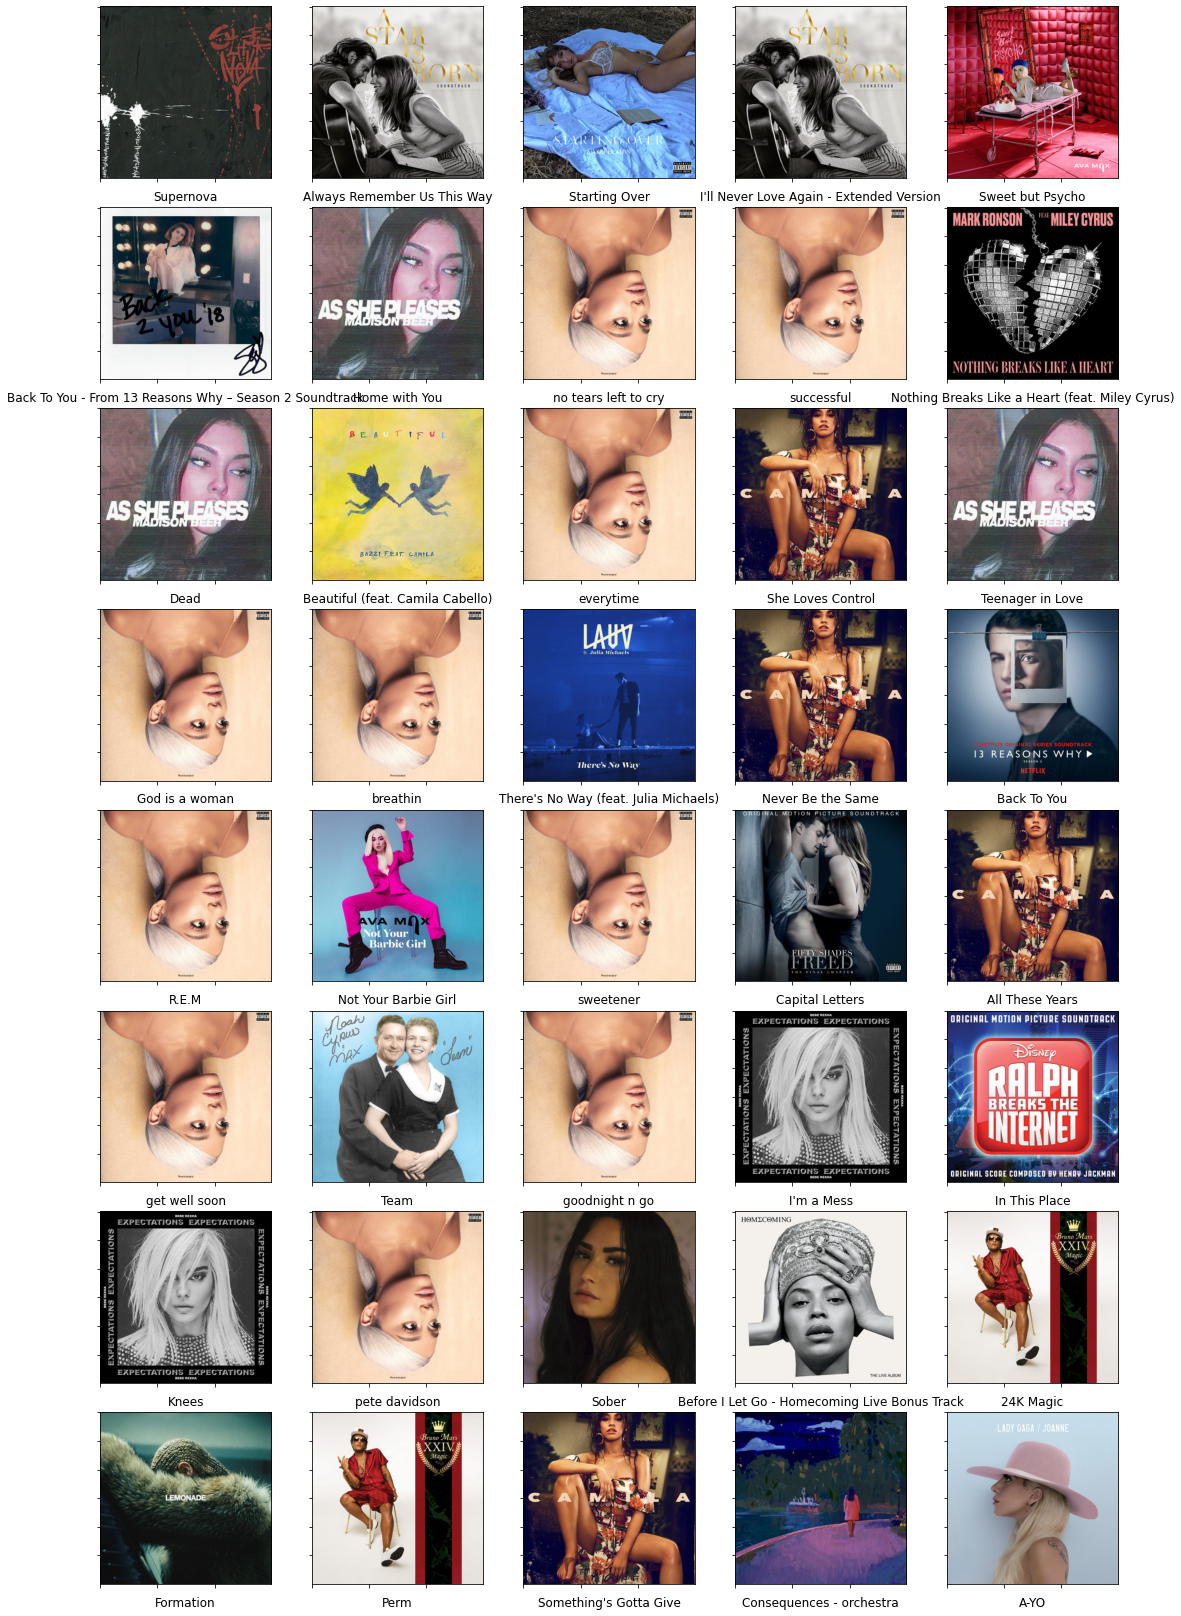

In [63]:
visualize_songs(pop_top40)

In [64]:
pop_top40['artists_song']

149291                                Ansel ElgortSupernova
77456                  Lady GagaAlways Remember Us This Way
55140                            Niykee HeatonStarting Over
77433     Lady GagaI'll Never Love Again - Extended Version
146924                              Ava MaxSweet but Psycho
36896     Selena GomezBack To You - From 13 Reasons Why ...
67297                             Madison BeerHome with You
148156                    Ariana Grandeno tears left to cry
148153                              Ariana Grandesuccessful
65581     Mark RonsonNothing Breaks Like a Heart (feat. ...
67300                                      Madison BeerDead
144737                BazziBeautiful (feat. Camila Cabello)
148165                               Ariana Grandeeverytime
135412                      Camila CabelloShe Loves Control
67292                          Madison BeerTeenager in Love
148203                          Ariana GrandeGod is a woman
148166                                Ar

In [65]:
rap_top40 = generate_playlist_recos(spotify_df, complete_feature_set_playlist_vector_rap, complete_feature_set_nonplaylist_rap)

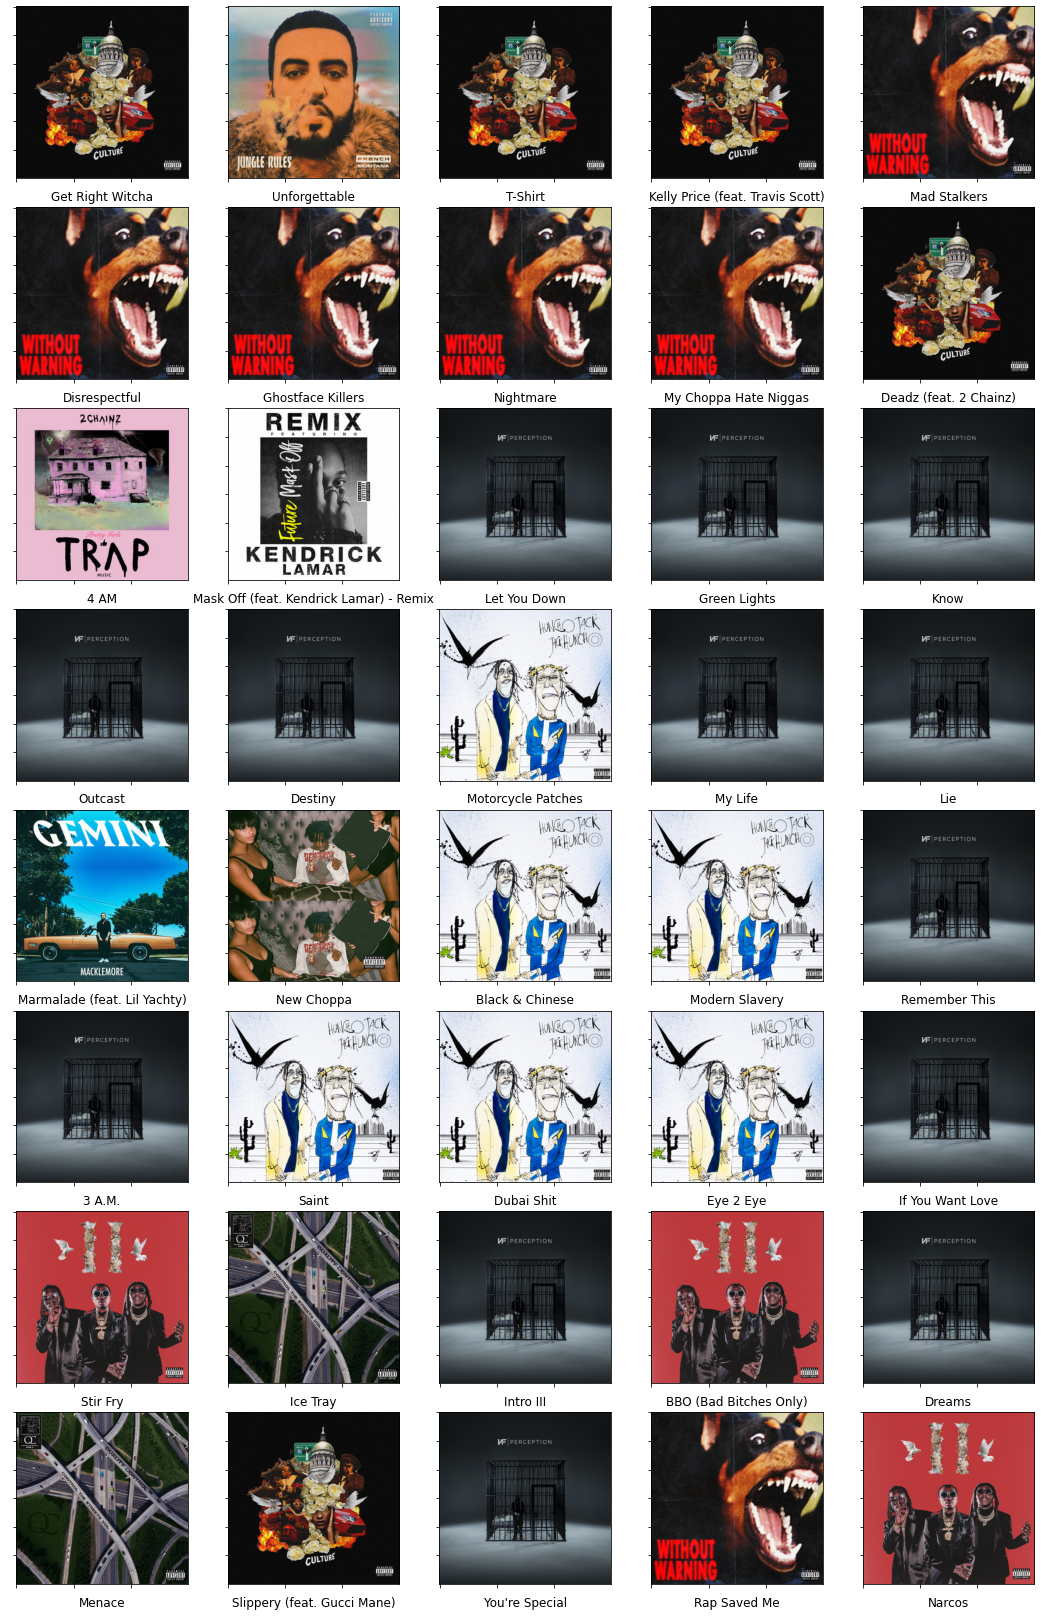

In [66]:
visualize_songs(rap_top40)